In [1]:
# -*- coding: utf-8 -*-

import torch
from kan import *
from kan.utils import create_dataset
from sympy import symbols
from kan.compiler import kanpiler
from kan.feynman import get_feynman_dataset
from kan.MLP import MLP
import matplotlib.pyplot as plt

c:\ProgramData\anaconda3\envs\pykan-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:

# Set default precision and device
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


*EX1:KAN's interpretability*


>>> KAN可解释性示例：
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-02 | test_loss: 1.79e-02 | reg: 5.71e+00 | : 100%|█| 50/50 [00:11<00:00,  4.19it


saving model version 0.1


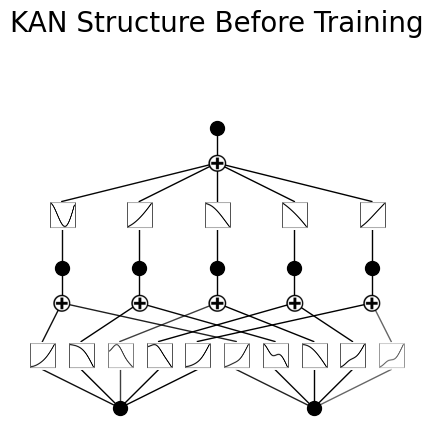

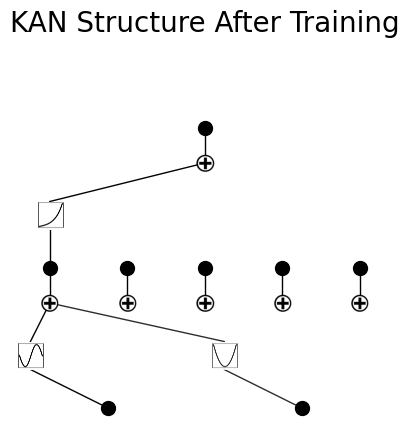

In [52]:

# 1. 可解释性示例
print("\n>>> KAN可解释性示例：")
f1 = lambda x: torch.exp(torch.sin(torch.pi * x[:,[0]]) + x[:,[1]]**2)
dataset1 = create_dataset(f1, n_var=2, device=device)
model1 = KAN(width=[2, 5, 1], grid=3, k=3, seed=42, device=device)
model1(dataset1['train_input'])  # 初始化状态
model1.plot(title="KAN Structure Before Training")
model1.fit(dataset1, opt="LBFGS", steps=50, lamb=0.001)
model1.plot(title="KAN Structure After Training")



*EX2:Comparison between KAN and MLP given same para setting: sample and more samples*

In [ ]:
# 2. 与MLP对比
print("\n>>> KAN vs. MLP：")
mlp1 = MLP(width=[2, 5, 1]).to(device)
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(mlp1.parameters(), lr=1e-3)

for epoch in range(2000):
    mlp1.train()
    opt.zero_grad()
    pred = mlp1(dataset1['train_input'])
    loss = loss_fn(pred, dataset1['train_label'])
    loss.backward()
    opt.step()

# 评估 RMSE
mlp1.eval()
with torch.no_grad():
    pred_kan = model1(dataset1['test_input'])
    pred_mlp = mlp1(dataset1['test_input'])
    rmse_kan = torch.sqrt(torch.mean((pred_kan - dataset1['test_label'])**2)).item()
    rmse_mlp = torch.sqrt(torch.mean((pred_mlp - dataset1['test_label'])**2)).item()
    print(f"RMSE (KAN): {rmse_kan:.4f}")
    print(f"RMSE (MLP): {rmse_mlp:.4f}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
loss_fn = torch.nn.MSELoss()

kan_train_logs, kan_test_logs = [], []
mlp_train_logs, mlp_test_logs = [], []

print("\n>>> Feynman 方程拟合对比（自动遍历所有可用问题）")

for problem_id in range(1, 15):
    try:
        input_vars, expr, f, ranges = get_feynman_dataset(problem_id)
    except:
        continue

    print(f"\n=== Problem {problem_id} ===")
    print(f"表达式: {expr}")

    # 数据集
    n_var = len(input_vars)
    dataset = create_dataset(f, n_var=n_var, ranges=ranges, device=device)

    # === KAN ===
    model = KAN(width=[n_var, 10, 1], grid=5, k=3, seed=42, device=device)
    kan_train, kan_test = [], []
    for _ in range(15):
        model.fit(dataset, opt="LBFGS", steps=1, lamb=1e-3)
        with torch.no_grad():
            pred_train = model(dataset['train_input'])
            pred_test = model(dataset['test_input'])
            kan_train.append(loss_fn(pred_train, dataset['train_label']).item())
            kan_test.append(loss_fn(pred_test, dataset['test_label']).item())
    model.plot(title=f"KAN Structure for Problem {problem_id}")
    kan_train_logs.append(kan_train)
    kan_test_logs.append(kan_test)

    # === MLP ===
    mlp = MLP(width=[n_var, 10, 1]).to(device)
    opt = torch.optim.LBFGS(mlp.parameters(), lr=1.0, max_iter=1)

    mlp_train, mlp_test = [], []
    for _ in range(15):
        def closure():
            opt.zero_grad()
            pred = mlp(dataset['train_input'])
            loss = loss_fn(pred, dataset['train_label'])
            loss.backward()
            return loss
        try:
            opt.step(closure)
            with torch.no_grad():
                pred_train = mlp(dataset['train_input'])
                pred_test = mlp(dataset['test_input'])
                mlp_train.append(loss_fn(pred_train, dataset['train_label']).item())
                mlp_test.append(loss_fn(pred_test, dataset['test_label']).item())
        except:
            mlp_train.append(float('inf'))
            mlp_test.append(float('inf'))

    mlp_train_logs.append(mlp_train)
    mlp_test_logs.append(mlp_test)

    print(f"KAN RMSE: {kan_test[-1]:.4f} | MLP RMSE: {mlp_test[-1]:.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 裁剪异常 loss（避免 MLP 某些爆炸情况）===
def clip_losses(logs, max_value=10.0):
    return [[min(loss, max_value) for loss in curve] for curve in logs]

kan_train_logs_clipped = clip_losses(kan_train_logs)
kan_test_logs_clipped = clip_losses(kan_test_logs)
mlp_train_logs_clipped = clip_losses(mlp_train_logs)
mlp_test_logs_clipped = clip_losses(mlp_test_logs)

# === 绘图：前10个 problem 的 loss 曲线 ===
steps = list(range(1, 16))
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for i in range(min(10, len(kan_train_logs_clipped))):
    axs[0].plot(steps, kan_train_logs_clipped[i], label=f"KAN-P{i+1}", linestyle="-", alpha=0.7)
    axs[0].plot(steps, mlp_train_logs_clipped[i], label=f"MLP-P{i+1}", linestyle="--", alpha=0.7)
    axs[1].plot(steps, kan_test_logs_clipped[i], label=f"KAN-P{i+1}", linestyle="-", alpha=0.7)
    axs[1].plot(steps, mlp_test_logs_clipped[i], label=f"MLP-P{i+1}", linestyle="--", alpha=0.7)

# 设置对数坐标
axs[0].set_yscale("log")
axs[1].set_yscale("log")

axs[0].set_title("Train Loss over 15 Steps (Log Scale, First 10 Feynman Problems)")
axs[1].set_title("Test Loss over 15 Steps (Log Scale)")
axs[1].set_xlabel("Training Step")
axs[0].set_ylabel("Loss (log)")
axs[1].set_ylabel("Loss (log)")
axs[0].legend(ncol=2, fontsize="small", loc="upper right")
axs[1].legend(ncol=2, fontsize="small", loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
kan_mean = np.mean(kan_test_logs_clipped, axis=0)
kan_std = np.std(kan_test_logs_clipped, axis=0)
mlp_mean = np.mean(mlp_test_logs_clipped, axis=0)
mlp_std = np.std(mlp_test_logs_clipped, axis=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(steps, kan_mean, label='KAN', color='tab:blue')
ax.fill_between(steps, kan_mean-kan_std, kan_mean+kan_std, color='tab:blue', alpha=0.3)
ax.plot(steps, mlp_mean, label='MLP', color='tab:orange', linestyle='--')
ax.fill_between(steps, mlp_mean-mlp_std, mlp_mean+mlp_std, color='tab:orange', alpha=0.3)

ax.set_yscale('log')
ax.set_title("Average Test Loss with StdDev (Log Scale)")
ax.set_xlabel("Step")
ax.set_ylabel("Loss (log)")
ax.legend()
plt.tight_layout()
plt.show()


*EX3:grid*

In [49]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device, train_num=1000)

grids = np.array([3,5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,5,1], grid=grids[i], k=k, seed=0, device=device)
    else:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']


cuda
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 3.86e-03 | test_loss: 3.98e-03 | reg: 1.56e+01 | : 100%|█| 50/50 [00:08<00:00,  5.91it


saving model version 0.1
saving model version 0.2


| train_loss: 1.40e-03 | test_loss: 1.46e-03 | reg: 1.54e+01 | : 100%|█| 50/50 [00:08<00:00,  5.97it


saving model version 0.3
saving model version 0.4


| train_loss: 2.64e-04 | test_loss: 2.93e-04 | reg: 1.52e+01 | : 100%|█| 50/50 [00:08<00:00,  6.20it


saving model version 0.5
saving model version 0.6


| train_loss: 1.25e-04 | test_loss: 1.56e-04 | reg: 1.52e+01 | : 100%|█| 50/50 [00:07<00:00,  6.46it


saving model version 0.7
saving model version 0.8


| train_loss: 8.73e-05 | test_loss: 1.80e-04 | reg: 1.52e+01 | : 100%|█| 50/50 [00:05<00:00,  8.73it


saving model version 0.9
saving model version 0.10


| train_loss: 4.27e-05 | test_loss: 2.85e-04 | reg: 1.52e+01 | : 100%|█| 50/50 [00:07<00:00,  6.55it

saving model version 0.11


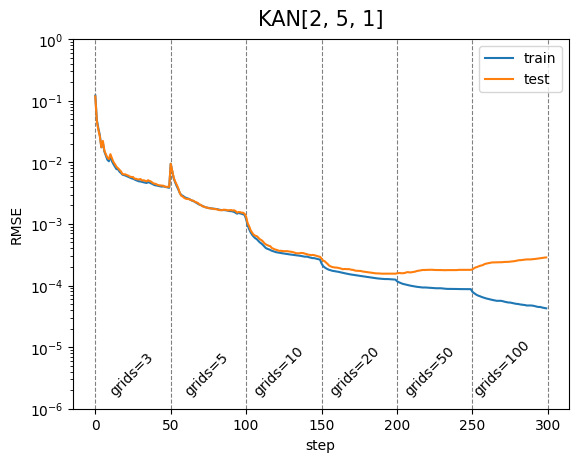

In [50]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.ylim(1e-6, 1)
plt.yscale('log')
plt.title('KAN[2, 5, 1]', fontsize=15, pad=10)
plt.grid(axis='x', linestyle='--', color='gray')
for i in range(grids.shape[0]):
    plt.text(steps * i + 40, 1.5e-6, f'grids={grids[i]}', rotation=45, ha='right', va='bottom')

*EX4:k*

In [ ]:
from kan import *
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 2)
dataset = create_dataset(f, n_var=2, device=device, train_num=1000)

ks = np.array([1, 2, 3, 4, 5, 6, 7])
steps = 10
grid = 10

train_losses_all = []
test_losses_all = []

for k in ks:
    model = KAN(width=[2, 1, 1], grid=grid, k=k, seed=0, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses_all.append(results['train_loss'])
    test_losses_all.append(results['test_loss'])

# Plotting
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("tab10")

for i, k in enumerate(ks):
    plt.plot(test_losses_all[i], label=f'k={k}', color=cmap(i), marker='o', linewidth=2)

plt.yscale('log')
plt.xlabel('Step', fontsize=13)
plt.ylabel('Test RMSE (log scale)', fontsize=13)
plt.title('Test RMSE for Different Spline Orders (k)', fontsize=15)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title='Spline order k', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("tab10")  # or "viridis", "plasma", etc.

for i, k in enumerate(ks):
    plt.plot(test_losses[i], label=f'k={k}', color=cmap(i), marker='o', linewidth=2)

plt.yscale('log')
plt.xlabel('Step', fontsize=13)
plt.ylabel('Test RMSE (log scale)', fontsize=13)
plt.title('Test RMSE for Different Spline Orders (k)', fontsize=15)
plt.legend(title='Spline order k', fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 引入3D支持
import numpy as np

# 创建数据
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(np.sin(np.pi * X) + Y ** 2)

# 创建图形和3D坐标轴
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面图
ax.plot_surface(X, Y, Z, cmap='viridis')  # 你也可以试试 'plasma', 'coolwarm' 等colormap

# 添加坐标轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# plt.show()
Z.shape